In [1]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import sem
from sklearn.linear_model import Lasso
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPRegressor
from time import time
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import BayesianRidge, LinearRegression
from scipy.stats import spearmanr
from sklearn.metrics import r2_score

In [2]:
## need biopython to run: https://anaconda.org/anaconda/biopython
from Bio.SeqUtils import MeltingTemp as mt
from Bio.Seq import Seq

In [3]:
## need OligoArrayAux to run: http://www.unafold.org/Dinamelt/software/OligoArrayAux.php
## install: https://libraries.io/pypi/oligo-melting
# import oligo_melting as OligoMelt

In [4]:
sns.set()

## Import data and graph

,Unnamed: 0,Expanded Sequence,sgRNA Score,sgRNA Rank,sgRNA Normalized,A1,AA1,AG1,AC1,AT1,...,TGT,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,Delta G
0,0,GGCCGTAATGGCTTCCTCGTGAGTTGGTCC,0.325738,2708.0,0.410978,0,0,0,0,0,...,0,0,1,1,0,0,1,1,0,-41
1,1,AGAAGCTCGTGCGAGTGATAGACCAGGAGA,0.162559,1558.0,0.236425,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,-39
2,2,ATGGCACGGACGGTATATGGCAGGAGGTGG,0.035653,360.0,0.054586,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,-41
3,3,TGGCTACTTCTGCGAGACACGGACAGGTCG,0.311042,2602.0,0.394889,0,0,0,0,0,...,0,0,1,0,1,0,0,1,0,-42
4,4,ACTTCGGCCCACGCTACTACAGTTCGGGCT,0.199951,1844.0,0.279835,1,0,0,1,0,...,0,0,1,0,0,0,0,1,0,-42


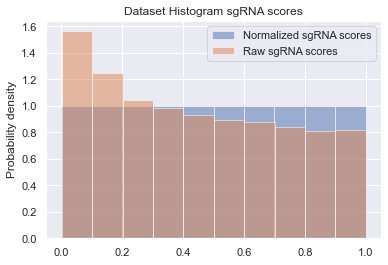

In [5]:
df = pd.read_csv("Doench_Fusi_V2_Featurized.csv")
plt.hist(df["sgRNA Normalized"], alpha=0.5, density=True, label='Normalized sgRNA scores')
plt.hist(df["sgRNA Score"], alpha=0.5, density=True, label='Raw sgRNA scores')
plt.ylabel('Probability density')
plt.title("Dataset Histogram sgRNA scores")
plt.legend()
df.head()

In [6]:
df.shape

(6588, 2496)

### Metrics

In [7]:
# Standardized metrics function to use on each model
def get_metrics(y_true, y_pred):
    #accuracy = accuracy_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    spr = spearmanr(y_true, y_pred)
    return {
        'mse' : mse,
        'r2' : r2,
        'spearman': spearmanr(y_true, y_pred)[0]
    }   


### Models

In [8]:
features = df.columns.values
y_feat = "sgRNA Normalized"
features = np.delete(features,0)
features = np.delete(features,0)
features = np.delete(features,0)
features = np.delete(features,0)
features = np.delete(features,0)
features = np.delete(features,0)
x_feat = features
x_feat = np.delete(x_feat, 0)
x_feat

array(['AG1', 'AC1', 'AT1', ..., 'TTC', 'TTT', 'Delta G'], dtype=object)

In [9]:
y = df.loc[:,y_feat].values
x = df[x_feat].values
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1
)

## 10-fold cross validation

In [10]:
def cross_validate_regression(model, df, x_feat_list, y_feat, n_splits=10):
    # computes the spearman correlation coefficient for each cross validated data set
    # takes in a model (estimator object), pandas dataframe, x features and the y-feature to predict, as well
    # as the number of splits (default is 10)
    #
    # returns a list of spearman correlation coefficients with length equal to the input n_splits
    
    # extract data into matrix
    x = df.loc[:, x_feat_list].values
    y_true = df.loc[:, y_feat].values
    
    kfold = KFold(n_splits=n_splits)
    
    # initialize an empty array same size as y_true
    y_pred = np.empty_like(y_true)
    
    # correlation list
    scc_list = np.array([])
    
    for train_idx, test_idx in kfold.split(x, y_true):
        # get training data
        x_train = x[train_idx, :]
        y_true_train = y_true[train_idx]

        # get testing data
        x_test = x[test_idx, :]
        y_true_test = y_true[test_idx]

        # train on training data
        model.fit(x_train, y_true_train)

        # estimate each penguin's species
        y_pred[test_idx] = model.predict(x_test)
        
        scc_list = np.append(scc_list, spearmanr(y_pred[test_idx], y_true[test_idx]).correlation)
    
    return scc_list

### Gradient-Boosted Regression Tree

In [11]:
params = {
    "n_estimators": 1000,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
}

params2 = {
    "n_estimators": 100,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
}

reg = ensemble.GradientBoostingRegressor(**params2)
reg.fit(X_train, y_train)
reg_ypred = reg.predict(X_test)

mse = mean_squared_error(y_test, reg_ypred)
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 0.0708


In [ ]:
get_metrics(y_test, reg_ypred)

In [13]:
ns = [1, 5, 10, 100, 1000, 1500]

gbr_df = pd.DataFrame(columns = ['mse', 'r2', 'spearman'])

for n in ns:
    params = {
    "n_estimators": n,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    }


    reg = ensemble.GradientBoostingRegressor(**params)
    reg.fit(X_train, y_train)
    reg_ypred = reg.predict(X_test)

    step_results = get_metrics(y_test, reg_ypred)
    gbr_df.loc[n] = [step_results['mse'], step_results['r2'], step_results['spearman']]


gbr_df

,mse,r2,spearman
1,0.082362,0.002712,0.357539
5,0.081508,0.013053,0.358314
10,0.080539,0.024788,0.367954
100,0.070757,0.143240,0.468252
1000,0.057865,0.299342,0.559580
1500,0.056666,0.313853,0.564466


In [14]:
# NOTE: this will take a while (~10 minutes) to run
gbrt_cvssc = cross_validate_regression(reg, df, x_feat, y_feat, 10)
gbrt_cvssc

##### Graphs of GBRT

In [ ]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

In [ ]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
# plt.yticks(pos, x_feat)[sorted_idx]
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=x_feat[sorted_idx], # this might break it
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

## Linear Regression

In [ ]:
ols = LinearRegression()
ols.fit(x, y)
ols_ypred = ols.predict(X_test)
#mse = mean_squared_error(y_test, ols.predict(X_test))
#print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

get_metrics(y_test, ols_ypred)

In [ ]:
lr_cvssc = cross_validate_regression(ols, df, x_feat, y_feat, 10)
lr_cvssc

##### Graphs for LR

In [ ]:
lw = 2
plt.figure(figsize=(6, 5))
plt.title("Weights of the model")
plt.plot(ols.coef_, color="lightblue", linewidth=lw, label="Linear Regression estimate")
plt.xlabel("Features")
plt.ylabel("Values of the weights")
plt.legend(loc="best", prop=dict(size=12))

In [ ]:
# Making a dataframe to sort feature importances
imp_df = pd.DataFrame()
imp_df['Features'] = x_feat
imp_df['Coefs'] = ols.coef_
imp_df = imp_df.sort_values(by=['Coefs'], ascending = False)
imp_df.head(10)

In [ ]:
imp_df.tail(10)

### Bayesian Ridge Regression

In [ ]:
# Fit the Bayesian Ridge Regression and an OLS for comparison
clf = BayesianRidge(compute_score=True)
clf.fit(x, y)

clf_ypred = clf.predict(X_test)
get_metrics(y_test, clf_ypred)

In [ ]:
brr_cvssc = cross_validate_regression(clf, df, x_feat, y_feat, 10)
brr_cvssc

##### Graphs

In [ ]:
'''clf_df = pd.DataFrame()
clf_df['Features'] = x_feat
clf_df['Coefs'] = clf.coef_
clf_df = clf_df.sort_values(by=['Coefs'], ascending = False)
clf_df.head(10)'''

In [ ]:
lw = .5
plt.figure(figsize=(16, 5))
plt.title("Weights of the model")
# plt.plot(ols.coef_, color="lightblue", linestyle="--", label="Linear Regression estimate")
plt.plot(clf.coef_, color="lightgreen", linewidth=lw, label="Bayesian Ridge estimate")
plt.xlabel("Features")
plt.ylabel("Values of the weights")
plt.legend(loc="best", prop=dict(size=12))

## Neural Network Regressor

In [ ]:
print("Training MLPRegressor...")
tic = time()
est = make_pipeline(
    QuantileTransformer(),
    MLPRegressor(
        # Params from grid search
        hidden_layer_sizes=(100, 100),
        learning_rate_init=0.0005,
        early_stopping=True,
        random_state=0,
        activation='tanh',
    ),
)
est.fit(X_train, y_train)
est_ypred = est.predict(X_test)
print(f"done in {time() - tic:.3f}s")
print(f"Test R2 score: {est.score(X_test, y_test):.2f}")

In [ ]:
get_metrics(y_test, est_ypred)

In [ ]:
nn_cvssc = cross_validate_regression(est, df, x_feat, y_feat, 10)
nn_cvssc

## Lasso Regressor

In [ ]:
las = Lasso(alpha = .0005, max_iter = 1000000, random_state = 42)
las.fit(x, y)
las_ypred = las.predict(X_test)

get_metrics(y_test, las_ypred)

In [ ]:
las_cvssc = cross_validate_regression(las, df, x_feat, y_feat, 10)
las_cvssc

In [ ]:
# Exploring features reduced to 0
lw = .5
plt.figure(figsize=(22, 8))
plt.plot(las.coef_)
plt.plot(clf.coef_)
plt.legend(loc="upper right")
plt.title('Lasso vs Bayesian Coefficient Weights')
plt.xlabel('Feature Number')
plt.ylabel('Weight')
fig.tight_layout()
plt.show()

In [ ]:
lasso_df = pd.DataFrame()

lasso_df['Features'] = x_feat
lasso_df['Coefs'] = las.coef_

threshold = .025
important_feats = lasso_df[abs(lasso_df['Coefs']) > threshold]
important_feats

In [ ]:
plt.plot(clf.coef_)

In [ ]:
'''from sklearn.model_selection import GridSearchCV

las_gs = Lasso();


# alpha = .001, max_iter = 1000000
las_param_list = {"alpha": [.05,.005,.0005,.00005], "fit_intercept" : [True, False], "max_iter": [100000]}

las_gridCV = GridSearchCV(estimator=las_gs, param_grid=las_param_list)

cv_scores = cross_validate_regression(las_gridCV, df, features, y_feat)

las_gridCV.best_estimator_'''

## Model Performance

In [ ]:
models = ['gbrt', 'lr', 'brr', 'nn', 'las']
values = [gbrt_cvssc.mean(), lr_cvssc.mean(), brr_cvssc.mean(), nn_cvssc.mean(), las_cvssc.mean()]
# error = [sem(gbrt_cvssc), sem(lr_cvssc), sem(brr_cvssc), sem(nn_cvssc)]
error = [gbrt_cvssc.std(), lr_cvssc.std(), brr_cvssc.std(), nn_cvssc.std(), las_cvssc.std()]

plt.bar(models, values, yerr=error, alpha=0.6)

In [ ]:
print(get_metrics(y_test, reg_ypred))
print(get_metrics(y_test, ols_ypred))
print(get_metrics(y_test, clf_ypred))
print(get_metrics(y_test, est_ypred))
print(get_metrics(y_test, las_ypred))

In [ ]:
model_names = ['GB Reg Tree', 'Linear Reg', 'Bayesian Ridge Reg', 'Neural Network Reg']
metric_names = ['mse', 'r2', 'spearman']

metrics_dict = {
    "reg" : get_metrics(y_test, reg_ypred),
    "ols" : get_metrics(y_test, ols_ypred),
    "clf" : get_metrics(y_test, clf_ypred),
    "est" : get_metrics(y_test, est_ypred)
    #, "las" : get_metrics(y_test, las_ypred)
}

metrics_df = pd.DataFrame(index = model_names, columns = metric_names)

for metric in metric_names:
    metric_list = []
    for model in metrics_dict:
        value = metrics_dict[model][metric]
        metric_list.append(value)
    metrics_df[metric] = metric_list

metrics_df['Model'] = metrics_df.index
metrics_df

In [ ]:
metrics_df.plot(
        x='Model',
        kind='bar',
        stacked=False,
        title='Grouped Bar Graph with dataframe')